In [33]:
import pandas as pd

# Read the xls file
df = pd.read_excel('cerevisiae_data.xls')

# Print the number of lines in the file
print(len(df), "rows loaded")


essential = 0
non_essential = 0

for i in range(len(df)):
    if df.loc[i, 'Essential'] == 1:
        essential += 1
    else:
        non_essential += 1
        

print("Essential columns:", essential)
print("Non-Essential columns:", non_essential)


print(df.head())



4728 rows loaded
Essential columns: 966
Non-Essential columns: 3762
    orf_id  Essential  orf_size  upstream_size  downstream_size  \
0  YAL001C          1      3573           1090               62   
1  YAL002W          0      3531            839               62   
2  YAL003W          1       987            742              839   
3  YAL005C          0      1929            742             1157   
4  YAL007C          0       648           1157              187   

   upstream_conservation  downstream_conservation  recombination  \
0               0.000000                 0.274194           0.78   
1               0.678188                 0.274194           0.88   
2               0.665768                 0.632000           1.14   
3               0.646000                 0.489000           1.35   
4               0.576000                 0.256684           0.97   

   paralagous_count  phyletic_retention  ...  microtubule  mitochondrion  \
0                 0                   2  ...

In [34]:
from sklearn.model_selection import train_test_split


x = df.drop(columns=['Essential'])

y = df['Essential']

# Esegui la divisione del dataset in training e test, mantenendo la stessa proporzione
# di classi nel target 'Essential' (ad esempio geni essenziali e non essenziali) sia nel set di addestramento
# che in quello di test. L'argomento 'stratify=y' assicura che la distribuzione delle classi
# nel target sia proporzionale in entrambi i set, evitando sbilanciamenti che potrebbero
# influenzare negativamente il modello, specialmente con dati sbilanciati.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42, stratify=y)

print("Training set has", len(x_train), "rows")
print("Testing set has", len(x_test), "rows")


Training set has 2364 rows
Testing set has 2364 rows


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest

rf_model = RandomForestClassifier(
    n_estimators=300,           # Numero di alberi (default=100)
    max_depth=20,               # Profondità massima. Di default è None, ovvero i nodi non vengono limitati. Alberi più profondi possono catturare maggiori dettagli ma rischiano di sovradattarsi ai dati.
    min_samples_split=5,        # numero minimo di campioni richiesti per dividere un nodo Valori più alti riducono l'overfitting ma possono portare a modelli troppo semplici. (default=2)
    min_samples_leaf=2,         # Minimo campioni per foglia: Ogni foglia deve contenere almeno quel numero di campioni, riducendo la capacità dell'albero di adattarsi a dettagli troppo specifici.
    max_features='sqrt',        # Massimo numero di feature: Il numero di feature che ogni albero considera è la radice quadrata del numero totale di feature (es., se hai 100 feature, ogni albero considererà 10 feature).
    class_weight='balanced',    # Gestione delle classi sbilanciate.Pesa le classi per gestire dataset sbilanciati.  Migliora le prestazioni quando una classe è sottorappresentata.
    random_state=42,            # Seme casuale
    n_jobs=-1                   # Esecuzione parallela (-1 per utilizzare tutti i core)
)
rf_model.fit(x_train.drop(columns=['orf_id']), y_train)


# Predict on the test set
y_pred_rf = rf_model.predict(x_train.drop(columns=['orf_id']))

# Evaluate the model
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1881
           1       0.20      0.20      0.20       483

    accuracy                           0.67      2364
   macro avg       0.49      0.49      0.49      2364
weighted avg       0.67      0.67      0.67      2364

Accuracy: 0.6704737732656514


In [36]:
# Crea una tabella cosi 
# orf_id	essential	probability of being essential

predicted_results = pd.DataFrame(columns=['orf_id', 'essential', 'probability of being essential'])
predicted_results['orf_id'] = x_test["orf_id"]

# Calcola la probabilità che un gene sia essenziale
probabilities = rf_model.predict_proba(x_test.drop(
    columns=['orf_id']
))[:, 1]
predicted_results['probability of being essential'] = probabilities
predicted_results['essential'] = df['Essential']

print(predicted_results.head())

# Salva il dataframe in un file csv
# predicted_results.to_csv('genertaed_predictions.csv', index=False)



       orf_id  essential  probability of being essential
4410  YPL071C          0                        0.144271
4103  YOR071C          0                        0.032716
168   YBR017C          0                        0.383027
48    YAL059W          0                        0.260704
147   YBL101C          0                        0.179672


In [37]:
# Confronto le mie predizioni con le predizioni del paper

paper_df = pd.read_excel('paper_results.xls', sheet_name=["ec_genprot", "ec_genprot_no","sc_all", "sc_genprot","sc_genprot_no"])
ec_genprot = paper_df['ec_genprot']
ec_genprot_no = paper_df['ec_genprot_no']
sc_all = paper_df['sc_all']
sc_genprot = paper_df['sc_genprot']
sc_genprot_no = paper_df['sc_genprot_no']


# Per ora considero solo sc_all
researcher_results = sc_all
researcher_results.head()


,orf_id,essential,probability of being essential
0,YGR103W,1,0.996913
1,YLR002C,1,0.994500
2,YDR365C,1,0.994136
3,YDR496C,0,0.993297
4,YCR057C,1,0.993033


Merged rows: 2364
Mean Squared Error (MSE) between your model and researcher's model: 0.0256
R-squared (R²) between your model and researcher's model: 0.6726


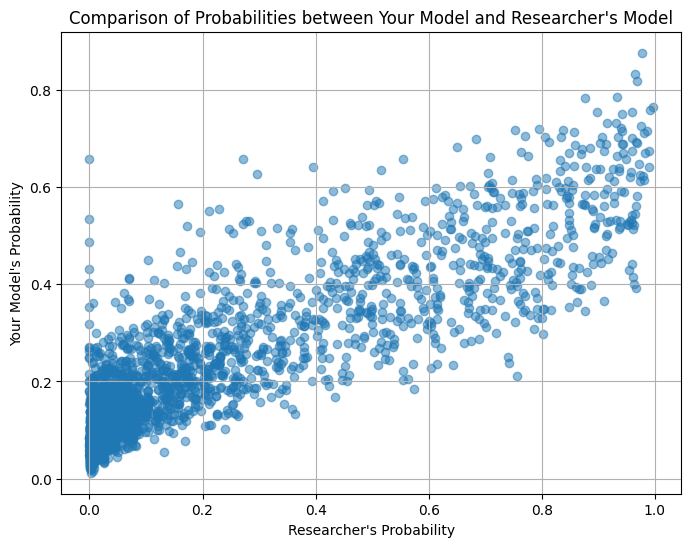

Correlation between the predicted probabilities: 0.8661
-----------------------------------------------------------------------
Metrics for your model:
Accuracy: 0.84
Precision: 0.73
Recall: 0.35
F1 Score: 0.47

Metrics for researcher's model:
Accuracy: 0.83
Precision: 0.60
Recall: 0.54
F1 Score: 0.57


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Assicurati che le colonne 'orf_id' siano dello stesso tipo e senza spazi
predicted_results['orf_id'] = predicted_results['orf_id'].astype(str).str.strip()
researcher_results['orf_id'] = researcher_results['orf_id'].astype(str).str.strip()

# Unisci i dataset basati sull'ID del gene
merged_results = pd.merge(predicted_results, researcher_results, on='orf_id', how='inner', suffixes=('_mine', '_research'))

print("Merged rows:", len(merged_results))


# Predizioni e ground truth
y_true = merged_results['essential_research']  # Ground truth (comune a entrambi)
y_pred_mine = merged_results['probability of being essential_mine']  # Le predizioni fatte dal tuo modello
y_pred_research = merged_results['probability of being essential_research']  # Le predizioni fatte dai ricercatori

# Calcola il Mean Squared Error (MSE) tra le probabilità
mse = mean_squared_error(y_pred_research, y_pred_mine)
print(f"Mean Squared Error (MSE) between your model and researcher's model: {mse:.4f}")

# Calcola il coefficiente di determinazione R^2, che misura la bontà dell'adattamento
r2 = r2_score(y_pred_research, y_pred_mine)
print(f"R-squared (R²) between your model and researcher's model: {r2:.4f}")

# Grafico a dispersione delle probabilità
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_research, y_pred_mine, alpha=0.5)
plt.xlabel("Researcher's Probability")
plt.ylabel("Your Model's Probability")
plt.title("Comparison of Probabilities between Your Model and Researcher's Model")
plt.grid(True)
plt.show()

# Facoltativo: puoi calcolare anche la correlazione tra le probabilità
correlation = np.corrcoef(y_pred_research, y_pred_mine)[0, 1]
print(f"Correlation between the predicted probabilities: {correlation:.4f}")


print("-----------------------------------------------------------------------")

# Calcolo l'accuraccy del modello della ricerca
# Trasformare le probabilità in etichette binarie (soglia 0.5)
y_pred_mine_binary = (y_pred_mine >= 0.5).astype(int)  # Se la probabilità è >= 0.5, predici 1 (essenziale)
y_pred_research_binary = (y_pred_research >= 0.5).astype(int)  # Lo stesso per i ricercatori

# Calcola le metriche per il tuo modello
accuracy_mine = accuracy_score(y_true, y_pred_mine_binary)
precision_mine = precision_score(y_true, y_pred_mine_binary)
recall_mine = recall_score(y_true, y_pred_mine_binary)
f1_mine = f1_score(y_true, y_pred_mine_binary)

# Calcola le metriche per i modelli dei ricercatori
accuracy_research = accuracy_score(y_true, y_pred_research_binary)
precision_research = precision_score(y_true, y_pred_research_binary)
recall_research = recall_score(y_true, y_pred_research_binary)
f1_research = f1_score(y_true, y_pred_research_binary)

# Stampa i risultati per il confronto
print("Metrics for your model:")
print(f"Accuracy: {accuracy_mine:.2f}")
print(f"Precision: {precision_mine:.2f}")
print(f"Recall: {recall_mine:.2f}")
print(f"F1 Score: {f1_mine:.2f}")

print("\nMetrics for researcher's model:")
print(f"Accuracy: {accuracy_research:.2f}")
print(f"Precision: {precision_research:.2f}")
print(f"Recall: {recall_research:.2f}")
print(f"F1 Score: {f1_research:.2f}")


